# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [8]:
client = MongoClient(mongod_connect)
db = client.lab9 # use or create a database named demo
tweet_collection = db.tweet_collection #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [4]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [9]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [18]:
count = 100 #number of returned tweets, default and max is 100
geocode = "38.4392897,-78.9412224,100mi"  # defin the location, in Harrisonburg, VA
q = "election"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [19]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Mon Nov 07 21:29:22 +0000 2022'
'Mon Nov 07 21:29:17 +0000 2022'
'Mon Nov 07 21:29:03 +0000 2022'
'Mon Nov 07 21:29:03 +0000 2022'
'Mon Nov 07 21:28:36 +0000 2022'
'Mon Nov 07 21:28:30 +0000 2022'
'Mon Nov 07 21:28:29 +0000 2022'
'Mon Nov 07 21:28:22 +0000 2022'
'Mon Nov 07 21:27:49 +0000 2022'
'Mon Nov 07 21:27:39 +0000 2022'
'Mon Nov 07 21:27:30 +0000 2022'
'Mon Nov 07 21:27:23 +0000 2022'
'Mon Nov 07 21:27:09 +0000 2022'
'Mon Nov 07 21:27:07 +0000 2022'
'Mon Nov 07 21:27:06 +0000 2022'
'Mon Nov 07 21:26:50 +0000 2022'
'Mon Nov 07 21:26:48 +0000 2022'
'Mon Nov 07 21:26:45 +0000 2022'
'Mon Nov 07 21:26:39 +0000 2022'
'Mon Nov 07 21:26:21 +0000 2022'
'Mon Nov 07 21:26:02 +0000 2022'
'Mon Nov 07 21:25:45 +0000 2022'
'Mon Nov 07 21:25:38 +0000 2022'
'Mon Nov 07 21:25:36 +0000 2022'
'Mon Nov 07 21:25:21 +0000 2022'
'Mon Nov 07 21:25:10 +0000 2022'
'Mon Nov 07 21:25:03 +0000 2022'
'Mon Nov 07 21:24:42 +0000 2022'
'Mon Nov 07 21:24:17 +0000 2022'
'Mon Nov 07 21:24:12 +0000 2022'
'Mon Nov 0

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [20]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Mon Nov 07 21:10:09 +0000 2022'
'Mon Nov 07 21:10:05 +0000 2022'
'Mon Nov 07 21:10:04 +0000 2022'
'Mon Nov 07 21:10:00 +0000 2022'
'Mon Nov 07 21:09:53 +0000 2022'
'Mon Nov 07 21:09:39 +0000 2022'
'Mon Nov 07 21:09:23 +0000 2022'
'Mon Nov 07 21:09:10 +0000 2022'
'Mon Nov 07 21:08:52 +0000 2022'
'Mon Nov 07 21:08:51 +0000 2022'
'Mon Nov 07 21:08:45 +0000 2022'
'Mon Nov 07 21:08:44 +0000 2022'
'Mon Nov 07 21:08:43 +0000 2022'
'Mon Nov 07 21:08:27 +0000 2022'
'Mon Nov 07 21:07:48 +0000 2022'
'Mon Nov 07 21:07:35 +0000 2022'
'Mon Nov 07 21:07:26 +0000 2022'
'Mon Nov 07 21:07:18 +0000 2022'
'Mon Nov 07 21:07:05 +0000 2022'
'Mon Nov 07 21:06:59 +0000 2022'
'Mon Nov 07 21:06:57 +0000 2022'
'Mon Nov 07 21:05:50 +0000 2022'
'Mon Nov 07 21:05:47 +0000 2022'
'Mon Nov 07 21:05:34 +0000 2022'
'Mon Nov 07 21:05:14 +0000 2022'
'Mon Nov 07 21:05:13 +0000 2022'
'Mon Nov 07 21:05:06 +0000 2022'
'Mon Nov 07 21:04:24 +0000 2022'
'Mon Nov 07 21:04:14 +0000 2022'
'Mon Nov 07 21:03:57 +0000 2022'
'Mon Nov 0

'Mon Nov 07 20:11:51 +0000 2022'
'Mon Nov 07 20:11:41 +0000 2022'
'Mon Nov 07 20:11:41 +0000 2022'
'Mon Nov 07 20:11:34 +0000 2022'
'Mon Nov 07 20:11:25 +0000 2022'
'Mon Nov 07 20:11:13 +0000 2022'
'Mon Nov 07 20:11:08 +0000 2022'
'Mon Nov 07 20:11:01 +0000 2022'
'Mon Nov 07 20:10:19 +0000 2022'
'Mon Nov 07 20:10:11 +0000 2022'
'Mon Nov 07 20:09:53 +0000 2022'
'Mon Nov 07 20:09:24 +0000 2022'
'Mon Nov 07 20:09:20 +0000 2022'
'Mon Nov 07 20:09:09 +0000 2022'
'Mon Nov 07 20:09:05 +0000 2022'
'Mon Nov 07 20:08:55 +0000 2022'
'Mon Nov 07 20:08:40 +0000 2022'
'Mon Nov 07 20:08:40 +0000 2022'
'Mon Nov 07 20:08:30 +0000 2022'
'Mon Nov 07 20:08:29 +0000 2022'
'Mon Nov 07 20:08:03 +0000 2022'
'Mon Nov 07 20:07:34 +0000 2022'
'Mon Nov 07 20:07:33 +0000 2022'
'Mon Nov 07 20:07:12 +0000 2022'
'Mon Nov 07 20:07:00 +0000 2022'
'Mon Nov 07 20:06:56 +0000 2022'
'Mon Nov 07 20:06:38 +0000 2022'
'Mon Nov 07 20:06:33 +0000 2022'
'Mon Nov 07 20:06:24 +0000 2022'
'Mon Nov 07 20:05:13 +0000 2022'
'Mon Nov 0

'Mon Nov 07 19:22:34 +0000 2022'
'Mon Nov 07 19:22:12 +0000 2022'
'Mon Nov 07 19:22:05 +0000 2022'
'Mon Nov 07 19:21:59 +0000 2022'
'Mon Nov 07 19:21:55 +0000 2022'
'Mon Nov 07 19:21:52 +0000 2022'
'Mon Nov 07 19:21:47 +0000 2022'
'Mon Nov 07 19:21:13 +0000 2022'
'Mon Nov 07 19:21:12 +0000 2022'
'Mon Nov 07 19:21:05 +0000 2022'
'Mon Nov 07 19:21:02 +0000 2022'
'Mon Nov 07 19:20:38 +0000 2022'
'Mon Nov 07 19:20:32 +0000 2022'
'Mon Nov 07 19:20:30 +0000 2022'
'Mon Nov 07 19:20:23 +0000 2022'
'Mon Nov 07 19:20:13 +0000 2022'
'Mon Nov 07 19:20:12 +0000 2022'
'Mon Nov 07 19:19:43 +0000 2022'
'Mon Nov 07 19:19:37 +0000 2022'
'Mon Nov 07 19:19:09 +0000 2022'
'Mon Nov 07 19:18:46 +0000 2022'
'Mon Nov 07 19:18:29 +0000 2022'
'Mon Nov 07 19:18:26 +0000 2022'
'Mon Nov 07 19:18:23 +0000 2022'
'Mon Nov 07 19:18:21 +0000 2022'
'Mon Nov 07 19:18:19 +0000 2022'
'Mon Nov 07 19:18:13 +0000 2022'
'Mon Nov 07 19:17:38 +0000 2022'
'Mon Nov 07 19:17:36 +0000 2022'
'Mon Nov 07 19:17:24 +0000 2022'
'Mon Nov 0

'Mon Nov 07 18:37:46 +0000 2022'
'Mon Nov 07 18:37:21 +0000 2022'
'Mon Nov 07 18:37:16 +0000 2022'
'Mon Nov 07 18:36:58 +0000 2022'
'Mon Nov 07 18:36:53 +0000 2022'
'Mon Nov 07 18:35:46 +0000 2022'
'Mon Nov 07 18:35:01 +0000 2022'
'Mon Nov 07 18:35:00 +0000 2022'
'Mon Nov 07 18:35:00 +0000 2022'
'Mon Nov 07 18:35:00 +0000 2022'
'Mon Nov 07 18:34:58 +0000 2022'
'Mon Nov 07 18:34:45 +0000 2022'
'Mon Nov 07 18:34:30 +0000 2022'
'Mon Nov 07 18:34:25 +0000 2022'
'Mon Nov 07 18:33:33 +0000 2022'
'Mon Nov 07 18:33:32 +0000 2022'
'Mon Nov 07 18:33:29 +0000 2022'
'Mon Nov 07 18:33:26 +0000 2022'
'Mon Nov 07 18:33:23 +0000 2022'
'Mon Nov 07 18:33:13 +0000 2022'
'Mon Nov 07 18:33:05 +0000 2022'
'Mon Nov 07 18:33:02 +0000 2022'
'Mon Nov 07 18:32:48 +0000 2022'
'Mon Nov 07 18:32:34 +0000 2022'
'Mon Nov 07 18:32:04 +0000 2022'
'Mon Nov 07 18:31:45 +0000 2022'
'Mon Nov 07 18:31:33 +0000 2022'
'Mon Nov 07 18:31:28 +0000 2022'
'Mon Nov 07 18:30:59 +0000 2022'
'Mon Nov 07 18:30:25 +0000 2022'
'Mon Nov 0

'Mon Nov 07 17:39:27 +0000 2022'
'Mon Nov 07 17:38:47 +0000 2022'
'Mon Nov 07 17:38:37 +0000 2022'
'Mon Nov 07 17:38:34 +0000 2022'
'Mon Nov 07 17:38:26 +0000 2022'
'Mon Nov 07 17:38:25 +0000 2022'
'Mon Nov 07 17:38:11 +0000 2022'
'Mon Nov 07 17:38:07 +0000 2022'
'Mon Nov 07 17:38:03 +0000 2022'
'Mon Nov 07 17:37:49 +0000 2022'
'Mon Nov 07 17:37:25 +0000 2022'
'Mon Nov 07 17:37:09 +0000 2022'
'Mon Nov 07 17:37:00 +0000 2022'
'Mon Nov 07 17:36:54 +0000 2022'
'Mon Nov 07 17:36:42 +0000 2022'
'Mon Nov 07 17:36:36 +0000 2022'
'Mon Nov 07 17:36:10 +0000 2022'
'Mon Nov 07 17:36:08 +0000 2022'
'Mon Nov 07 17:35:59 +0000 2022'
'Mon Nov 07 17:35:28 +0000 2022'
'Mon Nov 07 17:35:10 +0000 2022'
'Mon Nov 07 17:35:04 +0000 2022'
'Mon Nov 07 17:34:44 +0000 2022'
'Mon Nov 07 17:34:24 +0000 2022'
'Mon Nov 07 17:34:23 +0000 2022'
'Mon Nov 07 17:34:19 +0000 2022'
'Mon Nov 07 17:33:38 +0000 2022'
'Mon Nov 07 17:33:00 +0000 2022'
'Mon Nov 07 17:32:56 +0000 2022'
'Mon Nov 07 17:32:55 +0000 2022'
'Mon Nov 0

'Mon Nov 07 16:51:46 +0000 2022'
'Mon Nov 07 16:51:27 +0000 2022'
'Mon Nov 07 16:51:03 +0000 2022'
'Mon Nov 07 16:50:48 +0000 2022'
'Mon Nov 07 16:50:43 +0000 2022'
'Mon Nov 07 16:50:41 +0000 2022'
'Mon Nov 07 16:50:26 +0000 2022'
'Mon Nov 07 16:50:10 +0000 2022'
'Mon Nov 07 16:50:08 +0000 2022'
'Mon Nov 07 16:50:05 +0000 2022'
'Mon Nov 07 16:50:00 +0000 2022'
'Mon Nov 07 16:49:46 +0000 2022'
'Mon Nov 07 16:49:32 +0000 2022'
'Mon Nov 07 16:48:52 +0000 2022'
'Mon Nov 07 16:48:51 +0000 2022'
'Mon Nov 07 16:48:43 +0000 2022'
'Mon Nov 07 16:48:16 +0000 2022'
'Mon Nov 07 16:48:01 +0000 2022'
'Mon Nov 07 16:47:45 +0000 2022'
'Mon Nov 07 16:47:37 +0000 2022'
'Mon Nov 07 16:47:15 +0000 2022'
'Mon Nov 07 16:46:58 +0000 2022'
'Mon Nov 07 16:46:40 +0000 2022'
'Mon Nov 07 16:46:23 +0000 2022'
'Mon Nov 07 16:46:13 +0000 2022'
'Mon Nov 07 16:46:08 +0000 2022'
'Mon Nov 07 16:46:00 +0000 2022'
'Mon Nov 07 16:45:55 +0000 2022'
'Mon Nov 07 16:45:10 +0000 2022'
'Mon Nov 07 16:45:10 +0000 2022'
'Mon Nov 0

'Mon Nov 07 15:58:11 +0000 2022'
'Mon Nov 07 15:58:10 +0000 2022'
'Mon Nov 07 15:58:01 +0000 2022'
'Mon Nov 07 15:57:57 +0000 2022'
'Mon Nov 07 15:57:56 +0000 2022'
'Mon Nov 07 15:57:54 +0000 2022'
'Mon Nov 07 15:57:44 +0000 2022'
'Mon Nov 07 15:57:14 +0000 2022'
'Mon Nov 07 15:57:03 +0000 2022'
'Mon Nov 07 15:56:56 +0000 2022'
'Mon Nov 07 15:56:48 +0000 2022'
'Mon Nov 07 15:56:42 +0000 2022'
'Mon Nov 07 15:56:36 +0000 2022'
'Mon Nov 07 15:56:33 +0000 2022'
'Mon Nov 07 15:56:03 +0000 2022'
'Mon Nov 07 15:56:02 +0000 2022'
'Mon Nov 07 15:55:55 +0000 2022'
'Mon Nov 07 15:55:28 +0000 2022'
'Mon Nov 07 15:55:21 +0000 2022'
'Mon Nov 07 15:55:11 +0000 2022'
'Mon Nov 07 15:55:10 +0000 2022'
'Mon Nov 07 15:54:54 +0000 2022'
'Mon Nov 07 15:54:38 +0000 2022'
'Mon Nov 07 15:54:38 +0000 2022'
'Mon Nov 07 15:54:29 +0000 2022'
'Mon Nov 07 15:54:27 +0000 2022'
'Mon Nov 07 15:54:27 +0000 2022'
'Mon Nov 07 15:54:18 +0000 2022'
'Mon Nov 07 15:54:17 +0000 2022'
'Mon Nov 07 15:54:04 +0000 2022'
'Mon Nov 0

'Mon Nov 07 15:14:50 +0000 2022'
'Mon Nov 07 15:14:33 +0000 2022'
'Mon Nov 07 15:14:27 +0000 2022'
'Mon Nov 07 15:14:20 +0000 2022'
'Mon Nov 07 15:13:42 +0000 2022'
'Mon Nov 07 15:12:43 +0000 2022'
'Mon Nov 07 15:12:36 +0000 2022'
'Mon Nov 07 15:12:34 +0000 2022'
'Mon Nov 07 15:12:00 +0000 2022'
'Mon Nov 07 15:12:00 +0000 2022'
'Mon Nov 07 15:12:00 +0000 2022'
'Mon Nov 07 15:11:59 +0000 2022'
'Mon Nov 07 15:11:45 +0000 2022'
'Mon Nov 07 15:11:26 +0000 2022'
'Mon Nov 07 15:10:47 +0000 2022'
'Mon Nov 07 15:10:38 +0000 2022'
'Mon Nov 07 15:10:24 +0000 2022'
'Mon Nov 07 15:10:14 +0000 2022'
'Mon Nov 07 15:10:12 +0000 2022'
'Mon Nov 07 15:10:01 +0000 2022'
'Mon Nov 07 15:09:32 +0000 2022'
'Mon Nov 07 15:09:31 +0000 2022'
'Mon Nov 07 15:09:22 +0000 2022'
'Mon Nov 07 15:09:22 +0000 2022'
'Mon Nov 07 15:09:09 +0000 2022'
'Mon Nov 07 15:08:51 +0000 2022'
'Mon Nov 07 15:08:48 +0000 2022'
'Mon Nov 07 15:08:44 +0000 2022'
'Mon Nov 07 15:08:24 +0000 2022'
'Mon Nov 07 15:08:24 +0000 2022'
'Mon Nov 0

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [21]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

2761
1873


Create a text index and print the Tweets containing specific keywords. 

In [22]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [23]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pprint to display tweets

In [24]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Advancement Project
text: You can report intimidation to the Election Protection Hotline: 1-866-OUR-VOTE

Okay now VOTE VOTE VOTE.
----
name: T. Johansson
text: @ewarren Vote for lower costs for families -- vote for fiscal responsibility.

Vote for democracy -- vote for Voter… https://t.co/pya2mQqVvG
----
name: 🇺🇸 Buck Joe Fiden 🇺🇸 ULTRA MAGA
text: @ProudElephantUS I vote on election day in person. Early voting and mail in voting is how they cheat!
----
name: IAFF Local 2498
text: Reminder to make plans to VOTE on November 8th 2022. or VOTE Early. EARLY VOTING IN-PERSON
You can vote early at yo… https://t.co/WX4b7B8uN3
----
name: Coalition on Human Needs
text: The election is TOMORROW!
What’s your vote plan? Do you have questions about in person voting or vote by mail? Head… https://t.co/XUvRQwzR9J
----
name: Robert B. Mueller
text: @SteveLittleRock Wow! And she voted with an ID just like all other Arkansans that voted or will voted. This voter s… https://t.co/O3CWcgKXdq
---

In [25]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pandas to display tweets

In [26]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status
0,636978efae3590829c17c5a2,Mon Nov 07 17:15:31 +0000 2022,1589667878122332160,1589667878122332160,You can report intimidation to the Election Pr...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.589668e+18,...,2,2,False,False,en,NaN,NaN,NaN,NaN,NaN
1,636978ddae3590829c17c24b,Mon Nov 07 19:46:24 +0000 2022,1589705850675134469,1589705850675134469,@ewarren Vote for lower costs for families -- ...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.589691e+18,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
2,636976eeae3590829c17bf15,Fri Nov 04 20:27:07 +0000 2022,1588628931737161729,1588628931737161729,@ProudElephantUS I vote on election day in per...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.588616e+18,...,0,5,False,False,en,NaN,NaN,NaN,NaN,NaN
3,636976f0ae3590829c17bf67,Fri Nov 04 13:45:57 +0000 2022,1588527975531974656,1588527975531974656,Reminder to make plans to VOTE on November 8th...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,4,7,False,False,en,False,NaN,NaN,NaN,NaN
4,636978fdae3590829c17c869,Mon Nov 07 15:10:24 +0000 2022,1589636391906205701,1589636391906205701,The election is TOMORROW!\nWhat’s your vote pl...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1,0,False,False,en,False,NaN,NaN,NaN,NaN
5,636978d7ae3590829c17c134,Mon Nov 07 20:42:34 +0000 2022,1589719985902845952,1589719985902845952,@SteveLittleRock Wow! And she voted with an ID...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.589702e+18,...,0,0,False,False,en,NaN,NaN,NaN,NaN,NaN
6,6369759cae3590829c17bd28,Mon Nov 07 21:09:04 +0000 2022,1589726652883668992,1589726652883668992,Episode 3 of the student-led Dukes Vote Podcas...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,0,False,False,en,False,NaN,NaN,NaN,NaN
7,636978f3ae3590829c17c67e,Mon Nov 07 16:32:26 +0000 2022,1589657036626673664,1589657036626673664,VOTE VOTE VOTE! Tomorrow is Election Day!\n\nL...,True,"{'hashtags': [{'text': 'PowerofTheBallot', 'in...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://www.loomly.com/"" rel=""nofollo...",NaN,...,0,0,False,False,en,False,NaN,NaN,NaN,NaN
8,6369759cae3590829c17bd4e,Mon Nov 07 18:57:40 +0000 2022,1589693583409352706,1589693583409352706,Say yes to voting. Tomorrow is Election Day ge...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,4,4,False,False,en,False,NaN,NaN,NaN,NaN
9,6369759cae3590829c17bd30,Mon Nov 07 20:48:19 +0000 2022,1589721430534811649,1589721430534811649,GO VOTE TOMORROW! We have to win this election...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,3,0,False,False,en,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

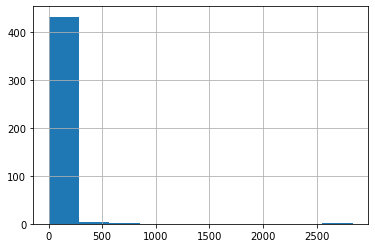

In [27]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count